# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Step 1: Initialize a tokenizer
tokenizer = Tokenizer()

# Step 2: Fit the tokenizer on the corpus
tokenizer.fit_on_texts(corpus)

# Check the word index
word_index = tokenizer.word_index
print("Word index:", word_index)


Word index: {'and': 1, 'the': 2, 'to': 3, 'of': 4, 'my': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10, 'with': 11, 'for': 12, 'is': 13, 'not': 14, 'love': 15, 'but': 16, 'a': 17, 'me': 18, 'thee': 19, 'so': 20, 'be': 21, 'as': 22, 'all': 23, 'you': 24, 'his': 25, 'which': 26, 'when': 27, 'it': 28, 'this': 29, 'by': 30, 'your': 31, 'doth': 32, 'do': 33, 'from': 34, 'on': 35, 'or': 36, 'no': 37, 'then': 38, 'have': 39, 'what': 40, 'are': 41, 'if': 42, 'more': 43, 'mine': 44, 'their': 45, 'shall': 46, 'sweet': 47, 'time': 48, 'will': 49, 'they': 50, 'beauty': 51, 'nor': 52, 'eyes': 53, 'art': 54, 'her': 55, 'heart': 56, 'yet': 57, 'o': 58, 'than': 59, 'can': 60, 'should': 61, 'thine': 62, 'now': 63, 'where': 64, 'make': 65, 'one': 66, 'hath': 67, 'he': 68, 'fair': 69, 'still': 70, 'how': 71, 'eye': 72, 'him': 73, 'like': 74, 'true': 75, 'see': 76, 'am': 77, 'she': 78, 'those': 79, 'though': 80, 'being': 81, 'some': 82, 'every': 83, 'such': 84, 'own': 85, 'were': 86, 'dost': 87, 'wh

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [23]:
# Step 2: Calculate the Vocabulary Size
total_words = len(tokenizer.word_index) + 1

# Print the total number of unique words
print("Total words (vocabulary size):", total_words)


Total words (vocabulary size): 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [25]:
# Step 3: Generate n-gram sequences
input_sequences = []

# Iterate through each line in the corpus
for line in corpus:
    # Convert each line into a sequence of integers
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Generate n-gram sequences
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Print the first 5 sequences to verify
print("First 5 sequences:", input_sequences[:5])


First 5 sequences: [[3, 2], [3, 2, 313], [3, 2, 313, 1375], [3, 2, 313, 1375, 4], [118, 1376]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Step 4: Calculate the length of the longest sequence
max_sequence_len = max([len(seq) for seq in input_sequences])

# Print the maximum sequence length
print("Max sequence length:", max_sequence_len)

# Step 5: Pad the sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Convert to numpy array
input_sequences = np.array(input_sequences)

# Print the shape of the padded sequences to verify
print("Shape of input sequences:", input_sequences.shape)


Max sequence length: 11
Shape of input sequences: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [27]:
# Step 6: Prepare Predictors and Labels

# Predictors: All elements except the last one
predictors = input_sequences[:, :-1]

# Labels: The last element of each sequence
labels = input_sequences[:, -1]

# Print the shape of predictors and labels to verify
print("Shape of predictors:", predictors.shape)
print("Shape of labels:", labels.shape)



Shape of predictors: (15484, 10)
Shape of labels: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [28]:
# Step 7: One-Hot Encode the Labels
labels = ku.to_categorical(labels, num_classes=total_words)

# Print the shape of the one-hot encoded labels to verify
print("Shape of one-hot encoded labels:", labels.shape)



Shape of one-hot encoded labels: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [30]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import regularizers

# Step 8: Initialize the Model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))

# Dropout Layer
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(100))

# Dense Layer (Intermediate) with ReLU and L2 regularization
model.add(Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Output Dense Layer with softmax activation
model.add(Dense(total_words, activation='softmax'))

# Print the model summary to verify
model.summary()




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [31]:
from tensorflow.keras.optimizers import Adam

# Step 9: Compile the Model
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

# Model is now ready to be trained



# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [38]:
model.build()
# Print the model summary
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,999,463 (76.29 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,332,976 (50.86 MB)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [33]:
# Train the model for 50 epochs
history = model.fit(predictors, labels, epochs=50, verbose=1)

# Print the training process complete message
print("Training complete.")


Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.0200 - loss: 7.3330
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.0206 - loss: 6.4756
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.0237 - loss: 6.4213
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.0316 - loss: 6.2878
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.0354 - loss: 6.1665
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.0392 - loss: 6.1057
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.0385 - loss: 6.0495
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.0438 - loss: 6.0070
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.0468 - loss: 5.8982
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.0493 - loss: 5.8138
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.0554 - loss: 5.7421
Epoch 12/50
484/484 ━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

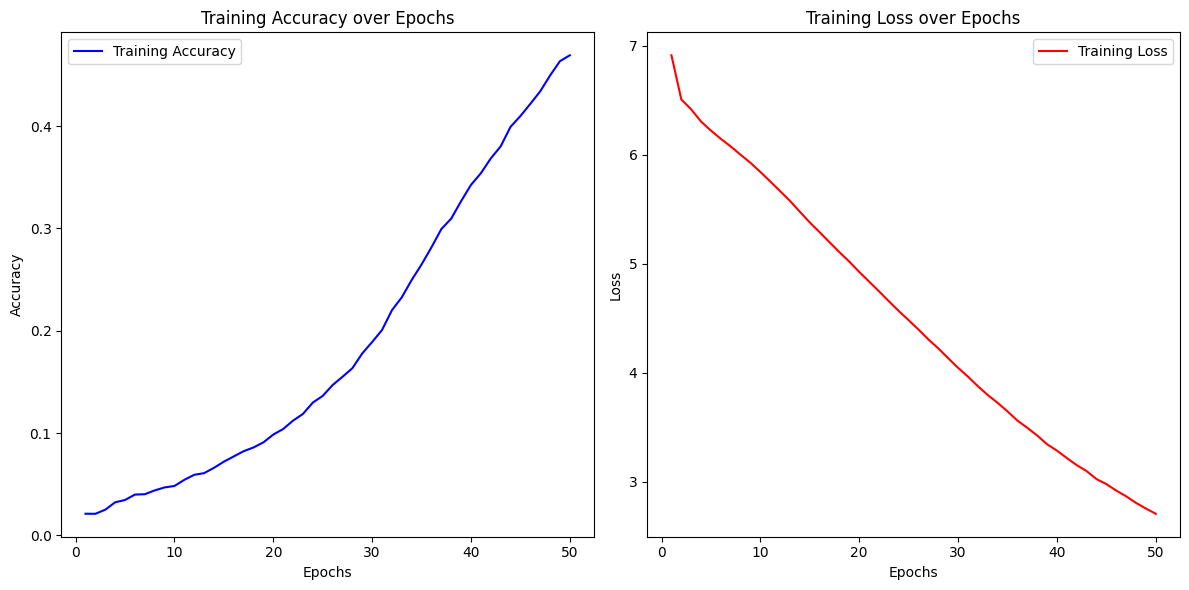

In [40]:
import matplotlib.pyplot as plt

# Step 13: Retrieve accuracy and loss from the history object
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

# Step 14: Plot the training accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [41]:
# Step 15: Generate Text with the Model

# Define seed text and the number of words to generate
seed_text = "Shall I enjoy my weekend"
next_words = 100  # Change this to the number of words you want to generate

for _ in range(next_words):
    # Convert seed text into a sequence of integers
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the sequence to match the input length of the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    
    # Choose the word with the highest probability
    predicted_word_index = np.argmax(predicted, axis=1)[0]
    
    # Get the word corresponding to the predicted index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break
    
    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the generated text
print(seed_text)

   


Shall I enjoy my weekend love despite thy effect in mind bosom quite wife decease date pride new near confined end ' 'will' bring burn ' bear me back again assured look wanting words appear foes race gems dead date brow date hate new date hate new days so prove hate kind on such young right ill deeds new bright ' see me thee so love you live well knows it so rare slain hate days keep more rare ' see you prove place thee well well the rest seat due on time one kind shines me alone new worth convertest told so heart so


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [42]:
# Step 16: Generate Text in a Loop

# Define seed text and number of words to generate
seed_text = "Shall I compare thee to a summer's day" #Write the text you want the model to use as a starting point"
next_words = 50  # Change this to however many words you want the model to generate

# Loop to generate words
for _ in range(next_words):
    # Convert seed text to sequence of integers
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad the token list to ensure the length is max_sequence_len-1
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word using the model
    predicted = model.predict(token_list, verbose=0)
    
    # Get the index of the most probable next word
    predicted_word_index = np.argmax(predicted, axis=1)[0]
    
    # Find the corresponding word for that index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break
    
    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the generated text
print(seed_text)



Shall I compare thee to a summer's day tend foes date date ill place on thee back open hate will be ' prove live tender'd rare ' do thee in me you ' be grow beard kind did stand thee so mine write i in thee you you will be art so near slain near new pride date


Experiment with at least 3 different seed_text strings and see what happens!

In [43]:
# Define seed texts and number of words to generate
experiments = [
    {"seed_text": "To be or not to be", "next_words": 20},
    {"seed_text": "I love thee more than words", "next_words": 20},
    {"seed_text": "The dark night whispers secrets", "next_words": 20}
]

# Loop through each experiment
for experiment in experiments:
    seed_text = experiment["seed_text"]
    next_words = experiment["next_words"]
    
    print(f"Starting text generation for: '{seed_text}'\n")
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        seed_text += " " + output_word
    
    print(f"Generated text: {seed_text}\n")


Starting text generation for: 'To be or not to be'

Generated text: To be or not to be therein on thee kind affords so near kind clears weep lie so hence arising 'will ' see me i do

Starting text generation for: 'I love thee more than words'

Generated text: I love thee more than words left things near slain free new face gems bow weep now behold tongue 'tis tongue too end back days will

Starting text generation for: 'The dark night whispers secrets'

Generated text: The dark night whispers secrets physic and mine eye gone still prove word back move me lost a tomb that thee doth break away your

